In [ ]:
!pip3 install panda
!pip3 install tensorflow
!pip3 install transformers
!pip3 install numpy 
!pip3 install seaborn 

  Created wheel for panda: filename=panda-0.3.1-py3-none-any.whl size=7256 sha256=3acc5f55ebf4389589a02b4985d0edbc14d57a20ba900517022f8ed3be13a362
  Stored in directory: /root/.cache/pip/wheels/e6/3d/81/a3665ce657d35359ca337b1db2975dbe5cd281a88b8982f6b6
Successfully built panda
     |████████████████████████████████| 2.6 MB 14.6 MB/s 
     |████████████████████████████████| 636 kB 56.4 MB/s 
     |████████████████████████████████| 895 kB 74.2 MB/s 
     |████████████████████████████████| 3.3 MB 60.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import neccessary library

In [ ]:
import pandas as pd
import tensorflow as tf
import transformers
from tensorflow.keras import layers
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os

#Set Global Parameter

In [ ]:
os.chdir("/content/drive/MyDrive/Colab_File")
print(os.getcwd())
path_train = './NLP/data/train_set.csv'
path_dev = './NLP/data/dev_set.csv'
max_length = 35
batch_size = 64
epochs = 10

/content/drive/MyDrive/Colab_File


#Load Data

In [ ]:

train_df = pd.read_csv(path_train)
dev_df = pd.read_csv(path_dev)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=2)
y_dev = tf.keras.utils.to_categorical(dev_df.label, num_classes=2)
train_df.head(20)

,query,clarifying_question,label
0,Find me information on sat,do you want general information about the test,0
1,Information about east ridge high school.,what information about east ridge high school ...,1
2,Tell me about of Ralph Owen Brester.,are you interested in learning more about ralp...,1
3,I want to learn about rock art.,are you looking for information about cave pai...,1
4,Which gps receiver I should buy,do you want to know how many types of coffee s...,0
5,What are specific dangers of asbestos?,what exactly do you wanto to know about the da...,1
6,tell me about evidence for evolution,are you looking for information about cave pai...,0
7,What is equal opportunity employer?,which ps 2 game franchises are you interested in,0
8,Tell me about defender,would you like to play atari arcade games online,0
9,Tell me more on Kansas city railroad,do you want to know about kennycaffey syndorme,1


#Dataset Analysis

dataset label distribution:
1    8581
0    8581
Name: label, dtype: int64


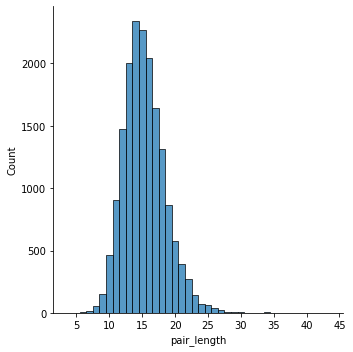

In [ ]:
def text_visualization(df):
    """
    show the distribuation of text pair length and amounts of label

    :param df: train/dev dataframe
    :return:
    """
    # tokenization:
    df_token1 = df['query'].apply(lambda x:x.split())
    df_token2 = df['clarifying_question'].apply(lambda x:x.split())

    # label amounts:
    print("dataset label distribution:")
    print(df.label.value_counts())

    # length distribution:
    counter1 = np.array([len(i) for i in df_token1.tolist()])
    counter2 = np.array([len(i) for i in df_token2.tolist()])
    counter = counter1 + counter2

    df_analysis = pd.DataFrame(counter, columns=['pair_length'])
    #df_analysis = pd.concat((df_analysis, df['label']), axis=1)

    sns.displot(df_analysis, x='pair_length', discrete=True)
text_visualization(train_df)

#Preprocessing

In [ ]:
def preprocessing(sent1, sent2):
    m = np.shape(sent1)[0]
    sent_sum = []
    for i in range(m):
        sent_plus = sent1[i] + ' [SEP] ' + sent2[i]
        sent_sum.append(sent_plus)

    return np.array(sent_sum).astype('str')

query_train = train_df['query'].values
clarify_question_train = train_df['clarifying_question'].values
query_dev = dev_df['query'].values
clarify_question_dev = dev_df['clarifying_question'].values

X_train = preprocessing(query_train, clarify_question_train)
X_dev = preprocessing(query_dev, clarify_question_dev)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=2)
y_dev = tf.keras.utils.to_categorical(dev_df.label, num_classes=2)

In [ ]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, sentence_pairs, labels, batch_size, max_length, shuffle=True, include_targets=True):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.max_length = max_length
        self.include_targets = include_targets
        self.tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self): # overload len function
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx): # overload getitem function, in oder to retrieve each element
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=self.max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_tensors="tf"
        )

        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            #labels = np.array(self.labels[indexes], dtype="float32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):

        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

train_data = BertSemanticDataGenerator(
    train_df[["query", "clarifying_question"]].values.astype("str"),
    train_df['label'].values,
    #train_df['sim_score'].values,
    batch_size=batch_size,
    max_length=max_length,
    shuffle=True,
)

valid_data = BertSemanticDataGenerator(
    dev_df[["query", "clarifying_question"]].values.astype("str"),
    dev_df['label'].values,
    #dev_df['sim_score'].values,
    batch_size=batch_size,
    max_length=max_length,
    shuffle=False,
)




#Create Network 

In [ ]:
input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")
token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")
bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
bert_model.trainable = False
bert_output = bert_model(
    [input_ids, attention_masks, token_type_ids]
)
sequence_output = bert_output.last_hidden_state
bi_lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(sequence_output)
avg_pool = layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = layers.GlobalMaxPooling1D()(bi_lstm)
concat = layers.concatenate([avg_pool, max_pool])
#layer1 = layers.Dense(256, activation="tanh")(pooler_output)
dropout = layers.Dropout(0.3)(concat)
output = layers.Dense(1, activation="sigmoid")(dropout)
#output = layers.Dense(1, activation="relu")(dropout)
model = tf.keras.models.Model(
    inputs=[input_ids, attention_masks, token_type_ids],
    outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    #loss="mean_squared_error",
    metrics=["accuracy"]
    #metrics=["mse"]
)

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

#Train a Model

In [ ]:
checkpoint_filepath = './NLP/result/my_checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                save_weights_only=True,
                                period=5,
                                verbose=1
                                )
model.fit(
        train_data,
        batch_size=batch_size,
        validation_data=valid_data,
        epochs=epochs,
        callbacks=[model_checkpoint_callback],
        verbose=1,
    )

Epoch 1/10
268/268 [==============================] - 56s 156ms/step - loss: 0.3095 - accuracy: 0.8631 - val_loss: 0.2179 - val_accuracy: 0.9035
Epoch 2/10
268/268 [==============================] - 39s 146ms/step - loss: 0.2245 - accuracy: 0.8967 - val_loss: 0.1870 - val_accuracy: 0.9135
Epoch 3/10
268/268 [==============================] - 39s 144ms/step - loss: 0.2030 - accuracy: 0.9064 - val_loss: 0.1608 - val_accuracy: 0.9254
Epoch 4/10
268/268 [==============================] - 38s 143ms/step - loss: 0.1805 - accuracy: 0.9181 - val_loss: 0.1588 - val_accuracy: 0.9275
Epoch 5/10
268/268 [==============================] - 39s 144ms/step - loss: 0.1615 - accuracy: 0.9283 - val_loss: 0.1299 - val_accuracy: 0.9391

Epoch 00005: saving model to ./NLP/result/my_checkpoint.ckpt
Epoch 6/10
268/268 [==============================] - 38s 144ms/step - loss: 0.1492 - accuracy: 0.9341 - val_loss: 0.1389 - val_accuracy: 0.9391
Epoch 7/10
268/268 [==============================] - 38s 144ms/step